In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

# Sample Code

$$\left(\frac{\Delta S}{S}\right) = \mu * \Delta t + \sigma * \epsilon * \sqrt{\Delta t}$$

In [2]:
u = 0.1
sigma = 0.07
t_step = 0.01
S0 = 100
St = S0

num_simulations = 1000
num_steps = 100

In [3]:
arr = []
for __ in range(num_simulations):
    St = S0
    arr_temp = []
    for _ in range(num_steps):
        arr_temp.append(St)
        St += St * u * t_step + St * sigma  * math.sqrt(t_step) * np.random.normal(0,1)
    arr.append(arr_temp)

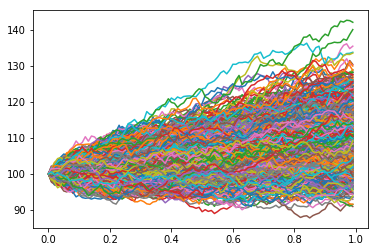

In [4]:
for x in arr:
    plt.plot(np.arange(0,1.0,0.01), x)

## Pricing European Options

Assume stock prices are lognormally distributed

$$ ln \left(\frac{\Delta S_{t + \Delta t}}{S_{t}}\right) = (\mu - \frac{\sigma^{2}}{2}) * \Delta t + \sigma * \epsilon * \sqrt{\Delta t} $$

--> 
$$ S_{t + \Delta t} = S_{t}\ exp[(\mu - \frac{\sigma^{2}}{2}) * \Delta t + \sigma * \epsilon * \sqrt{\Delta t} $$

In [5]:
def generate_asset_price(S0, u, sigma, T):
    return S0 * math.exp((u - sigma**2 / 2) * T + sigma * np.random.normal(0,1) * math.sqrt(T))

def call_payoff(ST, K):
    return max(ST-K, 0)

In [6]:
arr = []
for __ in range(num_simulations):
    St = S0
    arr_temp = []
    for _ in range(num_steps):
        arr_temp.append(St)
        St = St * math.exp((u - sigma**2 / 2) * t_step + sigma * np.random.normal(0,1) * math.sqrt(t_step))
    arr.append(arr_temp)

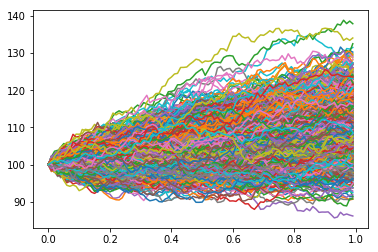

In [7]:
for x in arr:
    plt.plot(np.arange(0,1.0,0.01), x)

In [8]:
S = 857.29 # underlying price
v = 0.2076 # vol of 20.76%
r = 0.0014 # rate of 0.14%
T = (datetime.date(2013,9,21) - datetime.date(2013,9,3)).days / 365.0
K = 860.

simulations = 90000
payoffs = []
discount_factor = math.exp(-r * T)

In [9]:
for _ in range(simulations):
    payoffs.append(call_payoff(generate_asset_price(S, r, v, T), K) * discount_factor)
    
sum(payoffs) / len(payoffs)

14.467838476663742

## Pricing Barrier Options - Up-and-Out Call Option

In [10]:
# up-and-out call option
def barrier_call_payoff(S_path, K, barrier):
    if max(S_path) >= barrier:
        return 0
    elif S_path[-1] > K:
        return S_path[-1] - K
    else:
        return 0

# up-and-in call option
def barrier_call_barrier_in_payoff(S_path, K, barrier):
    if max(S_path) >= barrier:
        return max(0, S_path[-1] - K)
    else:
        return 0

In [11]:
S = 50 # underlying price
v = 0.3 # vol of 20.76%
r = 0.01 # rate of 0.14%
T = (datetime.date(2019,9,18) - datetime.date(2018,9,18)).days / 365.0
num_times = 1000
dt = 1./num_times
K = 50
barrier = 65

simulations = 10_000
payoffs = []
discount_factor = math.exp(-r * T)

In [12]:
for _ in range(simulations):
    S_path = np.zeros(num_times)
    S_path[0] = S
    for j in range(1, num_times):
        S_path[j] = generate_asset_price(S_path[j-1], r, v, dt)
        
    payoffs.append(barrier_call_payoff(S_path, K, barrier) * discount_factor)
    
option_price = np.mean(payoffs) 
payoff_var = np.std(payoffs)
upper_bound_95 = option_price + 1.96 * payoff_var / math.sqrt(simulations)
lower_bound_95 = option_price - 1.96 * payoff_var / math.sqrt(simulations)
print("Option price : {}".format(option_price))
print("{} barrier {} strike up and out 95% confident call price interval : [{} ; {}]".format(
        barrier, K, lower_bound_95, upper_bound_95))

Option price : 0.7946273216957715
65 barrier 50 strike up and out 95% confident call price interval : [0.7488926131400717 ; 0.8403620302514714]


## Pricing Asian Options

Asian options path-dependent. Stike price or payoff determined by average underlying asset price over option period.

https://quantipy.wordpress.com/2017/08/19/pricing-asian-arithmetic-option-using-monte-carlo-simulations/

In [15]:
# average underlying price = strike
def asian_call_payoff(S_path, barrier):
    K = np.mean(S_path)
    return max(S_path[-1] - K, 0)
    

# up-and-in call option
def asian_put_payoff(S_path, K, barrier):
    K = np.mean(S_path)
    return max(K - S_path[-1], 0)

In [17]:
for _ in range(simulations):
    S_path = np.zeros(num_times)
    S_path[0] = S
    for j in range(1, num_times):
        S_path[j] = generate_asset_price(S_path[j-1], r, v, dt)
        
    payoffs.append(asian_call_payoff(S_path, barrier) * discount_factor)
        
option_price = np.mean(payoffs)
payoff_var = np.std(payoffs)
upper_bound_95 = option_price + 1.96 * payoff_var / math.sqrt(simulations)
lower_bound_95 = option_price - 1.96 * payoff_var / math.sqrt(simulations)
print("Option price : {}".format(option_price))
print("95% confident asian call price interval : [{} ; {}]".format(lower_bound_95, upper_bound_95))

Option price : 2.627139299122715
95% confident asian call price interval : [2.52078590700032 ; 2.7334926912451105]
